# Multi-armed bandits techniques comparison

In this notebook we implement a testbed over which several algorithms will be run in order to check how do they perform in it when varying their main parameter. The algorithms will be tested against a stationary and a non stationary problem.

Notice that the epsilon-greedy algorithm applied in this notebook is always constant-step.

In [1]:
import numpy as np

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from tqdm import tqdm

ewma = lambda x: pd.Series(x).ewm(span=2000).mean()
%matplotlib inline

In [3]:
class TestBed:
    def __init__(self, n_actions, scale):
        self.n_actions = n_actions
        self.actions_q_values = np.random.normal(size=n_actions, scale=scale)
        self.initial_action_q_values = self.actions_q_values
        
    def reset_to_initial_q_values(self):
        #np.random.seed(655321)
        self.actions_q_values = self.initial_action_q_values
        
    def update_action_values(self):
        self.actions_q_values = self.actions_q_values + np.random.normal(size=self.n_actions, scale=0.01)
        
    def get_reward(self, action):
        return(np.random.normal(self.actions_q_values[action]))
    
    def get_optimal_reward(self):
        return(np.max(self.actions_q_values))
    
    def get_optimal_action(self):
        return(np.argmax(self.actions_q_values))
        

In [4]:
softmax = lambda x: np.exp(x)/np.sum(np.exp(x))

class EpsilonGreedyAgent():
    def __init__(self, alpha, epsilon, n_actions):
        self.alpha = alpha
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.q = np.zeros(self.n_actions)
    
    def choose_action(self):
        rand_epsilon = random.random()
        if rand_epsilon > self.epsilon: # Greedy
            action = np.argmax(self.q)
        else: # Random
            action = random.randint(0, self.n_actions-1)
        return action
    
    def update(self, action, reward):
        self.q[action] += self.alpha*(reward-self.q[action])
        
        
class EpsilonGreedyAgentOptimistic():
    def __init__(self, alpha, epsilon, n_actions, q0):
        self.alpha = alpha
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.q = q0*np.ones(self.n_actions)
    
    def choose_action(self):
        rand_epsilon = random.random()
        if rand_epsilon > self.epsilon: # Greedy
            action = np.argmax(self.q)
        else: # Random
            action = random.randint(0, self.n_actions-1)
        return action
    
    def update(self, action, reward):
        self.q[action] += self.alpha*(reward-self.q[action])
        
        
class UCBAgent():
    def __init__(self, alpha, c, n_actions):
        self.alpha = alpha
        self.c = c
        self.n_actions = n_actions
        self.q = np.zeros(self.n_actions)
        self.actions_count = np.zeros(self.n_actions)
    
    def choose_action(self):
        action = np.argmax(self.q + self.c*np.sqrt(np.log(np.sum(self.actions_count))/self.actions_count))
        self.actions_count[action] += 1
        return action
    
    def update(self, action, reward):
        self.q[action] += self.alpha*(reward-self.q[action])
        
        
class GradientBanditAgent():
    def __init__(self, alpha, n_actions):
        self.alpha = alpha
        self.n_actions = n_actions
        self.h = np.zeros(self.n_actions)
        self.pi = softmax(self.h)
        self.reward_avg = 0
        self.n = 0
    
    def choose_action(self):
        action = np.random.choice(list(range(self.n_actions)), p=self.pi/np.sum(self.pi))
        return action
    
    def update(self, action, reward):
        self.n += 1
        mask = np.zeros(self.n_actions)
        np.put(mask, action, 1)
        
        self.reward_avg += (1/self.n)*(reward-self.reward_avg)
        self.h = self.h + self.alpha*((mask-0.5)*2)*(reward-self.reward_avg)*(mask*(1-self.pi)+(1-mask)*(1-self.pi))
        self.pi = softmax(self.h)
        


In [5]:
env = TestBed(10, 0.75)

## Stationary environment 

In [6]:
parameter_values = [1/16384, 1/8192, 1/4096, 1/2048, 1/1024, 1/512, 1/256, 1/128, 1/64, 
                    1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4] 
n_experiments=100

final_rewards = {"epsilon_greedy": np.zeros(len(parameter_values)),
                 "epsilon_greedy_optimistic_initialization": np.zeros(len(parameter_values)),
                 "ucb": np.zeros(len(parameter_values)),
                 "gradient_bandit": np.zeros(len(parameter_values))}

In [7]:
for n in tqdm(range(n_experiments)):
    for m, param in enumerate(parameter_values):

        epsilon_greedy_agent = EpsilonGreedyAgent(alpha=0.1, epsilon=param, n_actions=env.n_actions)
        epsilon_greedy_optimistic_agent = EpsilonGreedyAgentOptimistic(alpha=0.1, 
                                                                       epsilon=0.1, 
                                                                       n_actions=env.n_actions,
                                                                       q0=param)
        ucb_agent = UCBAgent(alpha=0.1, c=param, n_actions=env.n_actions)
        gradient_bandit_agent = GradientBanditAgent(alpha=param, n_actions=env.n_actions)

        rewards = {"epsilon_greedy": [],
                   "epsilon_greedy_optimistic_initialization": [],
                   "ucb": [],
                   "gradient_bandit": []}

        for i in range(1000):
            epsilon_greedy_action = epsilon_greedy_agent.choose_action()
            epsilon_greedy_reward = env.get_reward(epsilon_greedy_action)
            epsilon_greedy_agent.update(epsilon_greedy_action, epsilon_greedy_reward)    
            rewards["epsilon_greedy"].append(epsilon_greedy_reward)

            epsilon_greedy_optimistic_action = epsilon_greedy_optimistic_agent.choose_action()
            epsilon_greedy_optimistic_reward = env.get_reward(epsilon_greedy_optimistic_action)
            epsilon_greedy_optimistic_agent.update(epsilon_greedy_optimistic_action, epsilon_greedy_optimistic_reward)    
            rewards["epsilon_greedy_optimistic_initialization"].append(epsilon_greedy_optimistic_reward)

            ucb_action = ucb_agent.choose_action()
            ucb_reward = env.get_reward(ucb_action)
            ucb_agent.update(ucb_action, ucb_reward)    
            rewards["ucb"].append(ucb_reward)

            gradient_bandit_action = gradient_bandit_agent.choose_action()
            gradient_bandit_reward = env.get_reward(gradient_bandit_action)
            gradient_bandit_agent.update(gradient_bandit_action, gradient_bandit_reward)    
            rewards["gradient_bandit"].append(gradient_bandit_reward)
        for model, r in rewards.items():
            final_rewards[model][m] += np.mean(r)/n_experiments

  0%|                                                                                                                                              | 0/100 [00:00<?, ?it/s]C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.03s/it]


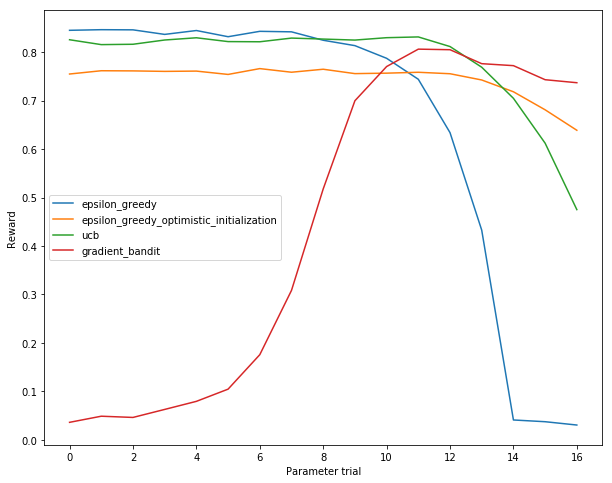

In [8]:
plt.figure(figsize=[10, 8])
for model_name, rewards in final_rewards.items():
    plt.plot(rewards)
plt.legend(list(final_rewards.keys()))
plt.ylabel("Reward")
plt.xlabel("Parameter trial")
plt.show()

## Non-stationary environment 

In [9]:
parameter_values = [1/16384, 1/8192, 1/4096, 1/2048, 1/1024, 1/512, 1/256, 1/128, 1/64, 
                    1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4] 
n_experiments=10

final_rewards = {"epsilon_greedy": np.zeros(len(parameter_values)),
                 "epsilon_greedy_optimistic_initialization": np.zeros(len(parameter_values)),
                 "ucb": np.zeros(len(parameter_values)),
                 "gradient_bandit": np.zeros(len(parameter_values))}

In [10]:
for n in tqdm(range(30)):
    for m, param in enumerate(parameter_values):
        env.reset_to_initial_q_values()
        epsilon_greedy_agent = EpsilonGreedyAgent(alpha=0.1, epsilon=param, n_actions=env.n_actions)
        epsilon_greedy_optimistic_agent = EpsilonGreedyAgentOptimistic(alpha=0.1, 
                                                                       epsilon=0.1, 
                                                                       n_actions=env.n_actions,
                                                                       q0=param)
        ucb_agent = UCBAgent(alpha=0.1, c=param, n_actions=env.n_actions)
        gradient_bandit_agent = GradientBanditAgent(alpha=param, n_actions=env.n_actions)

        rewards = {"epsilon_greedy": [],
                   "epsilon_greedy_optimistic_initialization": [],
                   "ucb": [],
                   "gradient_bandit": []}

        for i in range(200000):
            epsilon_greedy_action = epsilon_greedy_agent.choose_action()
            epsilon_greedy_reward = env.get_reward(epsilon_greedy_action)
            epsilon_greedy_agent.update(epsilon_greedy_action, epsilon_greedy_reward)    
            rewards["epsilon_greedy"].append(epsilon_greedy_reward)

            epsilon_greedy_optimistic_action = epsilon_greedy_optimistic_agent.choose_action()
            epsilon_greedy_optimistic_reward = env.get_reward(epsilon_greedy_optimistic_action)
            epsilon_greedy_optimistic_agent.update(epsilon_greedy_optimistic_action, epsilon_greedy_optimistic_reward)    
            rewards["epsilon_greedy_optimistic_initialization"].append(epsilon_greedy_optimistic_reward)

            ucb_action = ucb_agent.choose_action()
            ucb_reward = env.get_reward(ucb_action)
            ucb_agent.update(ucb_action, ucb_reward)    
            rewards["ucb"].append(ucb_reward)

            gradient_bandit_action = gradient_bandit_agent.choose_action()
            gradient_bandit_reward = env.get_reward(gradient_bandit_action)
            gradient_bandit_agent.update(gradient_bandit_action, gradient_bandit_reward)    
            rewards["gradient_bandit"].append(gradient_bandit_reward)
            
            env.update_action_values()
        for model, r in rewards.items():
            final_rewards[model][m] += np.mean(r[-100000:])/n_experiments

  0%|                                                                                                                                               | 0/30 [00:00<?, ?it/s]C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
  3%|████▍                                                                                                                               | 1/30 [07:15<3:30:23, 435.28s/it]C:\Users\Ivan Valles Pe

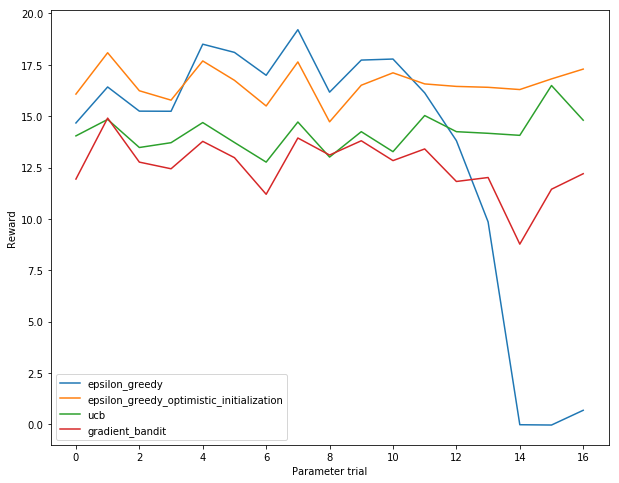

In [11]:
plt.figure(figsize=[10, 8])
for model_name, rewards in final_rewards.items():
    plt.plot(rewards)
plt.legend(list(final_rewards.keys()))
plt.ylabel("Reward")
plt.xlabel("Parameter trial")
plt.show()